# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

![Farmer in a field](farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

In this project, you will build multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

In [1]:
# Import all required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Define a global random seed.
RANDOM_SEED = 42

# Set the seed for Python's random module, NumPy.
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [2]:
# Load the dataset.
soil_data = pd.read_csv("soil_measures.csv")

# Display the first few rows of the dataset for inspection.
print("First 5 rows of the dataset:", end="\n\n")
display(soil_data.head(5))

# Display the shape of the dataset (rows, columns).
print(f"\nDataset shape: {soil_data.shape}", end="\n\n")

First 5 rows of the dataset:



,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice



Dataset shape: (2200, 5)



**1. Exploratory Data Analysis**

In [3]:
# Basic dataset information: summary of columns, non-null counts, and data types
print("Dataset Info:", end="\n\n")
soil_data.info()

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


In [4]:
# Display the number of unique values in each column.
print("Unique values per column:", end="\n\n")
print(soil_data.nunique())

Unique values per column:

N        137
P        117
K         73
ph      2200
crop      22
dtype: int64


In [5]:
# Display basic statistical description of numeric features.
print("Descriptive statistics for numeric features:", end="\n\n")
soil_data.describe()

Descriptive statistics for numeric features:



,N,P,K,ph
count,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,6.469480
std,36.917334,32.985883,50.647931,0.773938
min,0.000000,5.000000,5.000000,3.504752
25%,21.000000,28.000000,20.000000,5.971693
50%,37.000000,51.000000,32.000000,6.425045
75%,84.250000,68.000000,49.000000,6.923643
max,140.000000,145.000000,205.000000,9.935091


In [6]:
# Display unique crop values for understanding target categories.
print("Unique crop values:", end="\n\n")
print(soil_data["crop"].unique())

Unique crop values:

['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


In [7]:
# Display the counts of each unique value in the 'crop' column.
print("Value counts for 'crop':", end="\n\n")
print(soil_data["crop"].value_counts())

Value counts for 'crop':

crop
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64


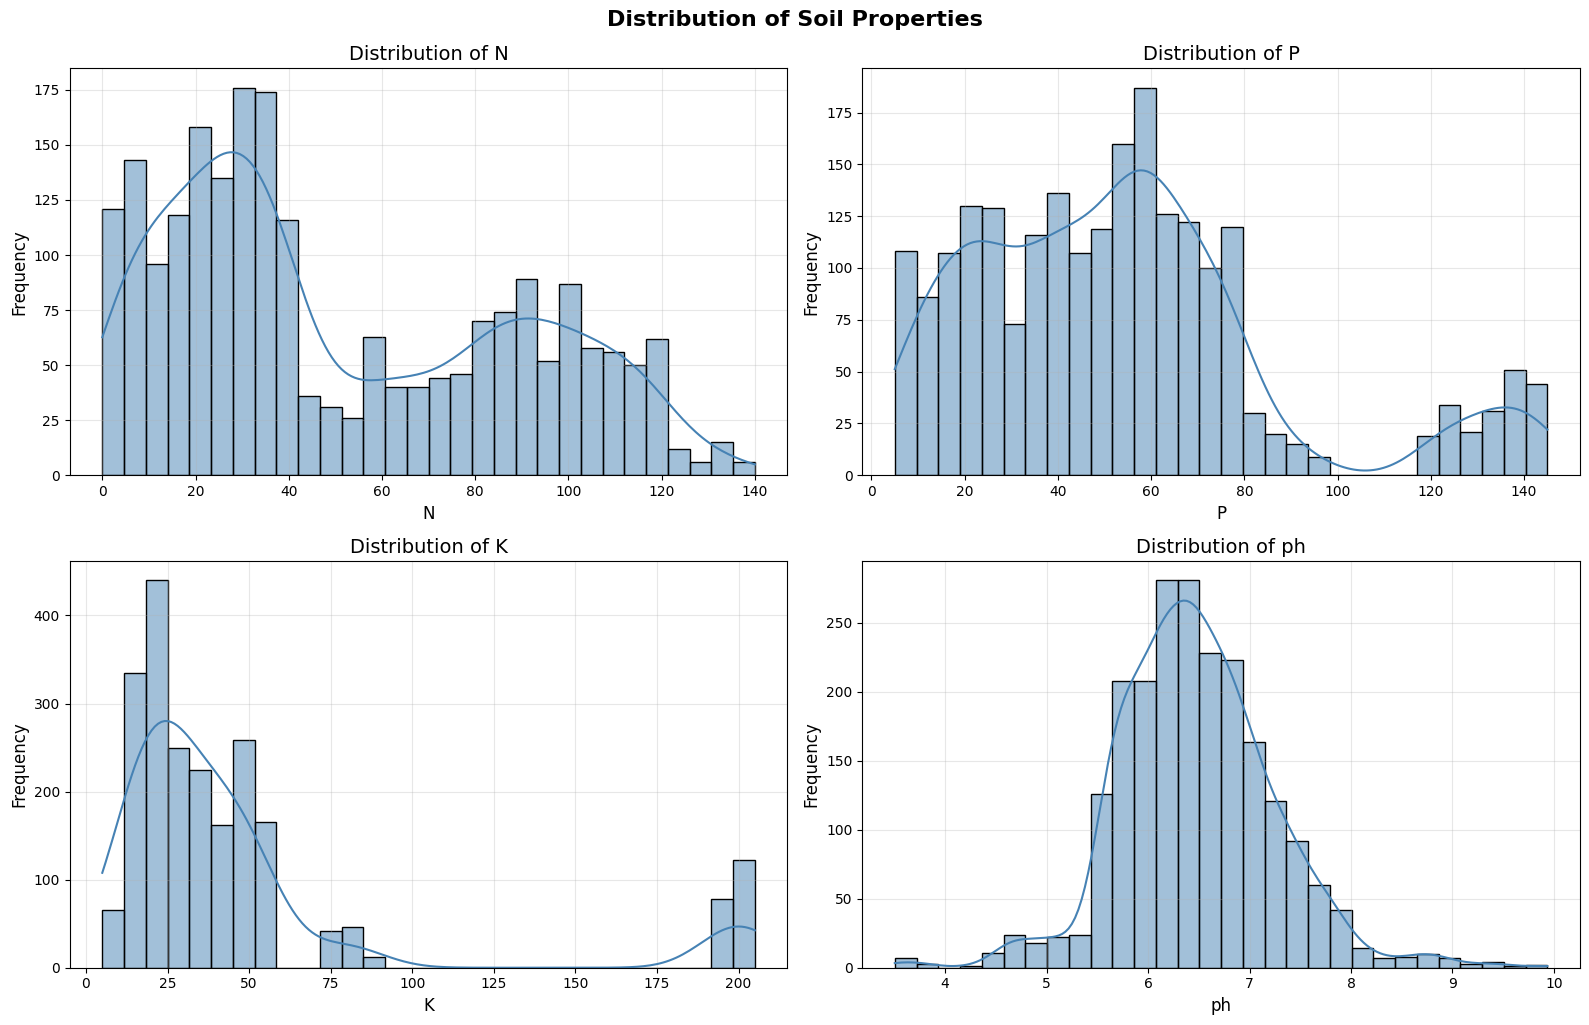

In [8]:
# Visualize the distribution of numeric features.
plt.figure(figsize=(16, 10))
numeric_columns = soil_data.select_dtypes(include=[np.number]).columns
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(soil_data[column], kde=True, bins=30, color="steelblue", edgecolor="black")
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Distribution of Soil Properties", fontsize=16, fontweight="bold", y=1.02)
plt.show()

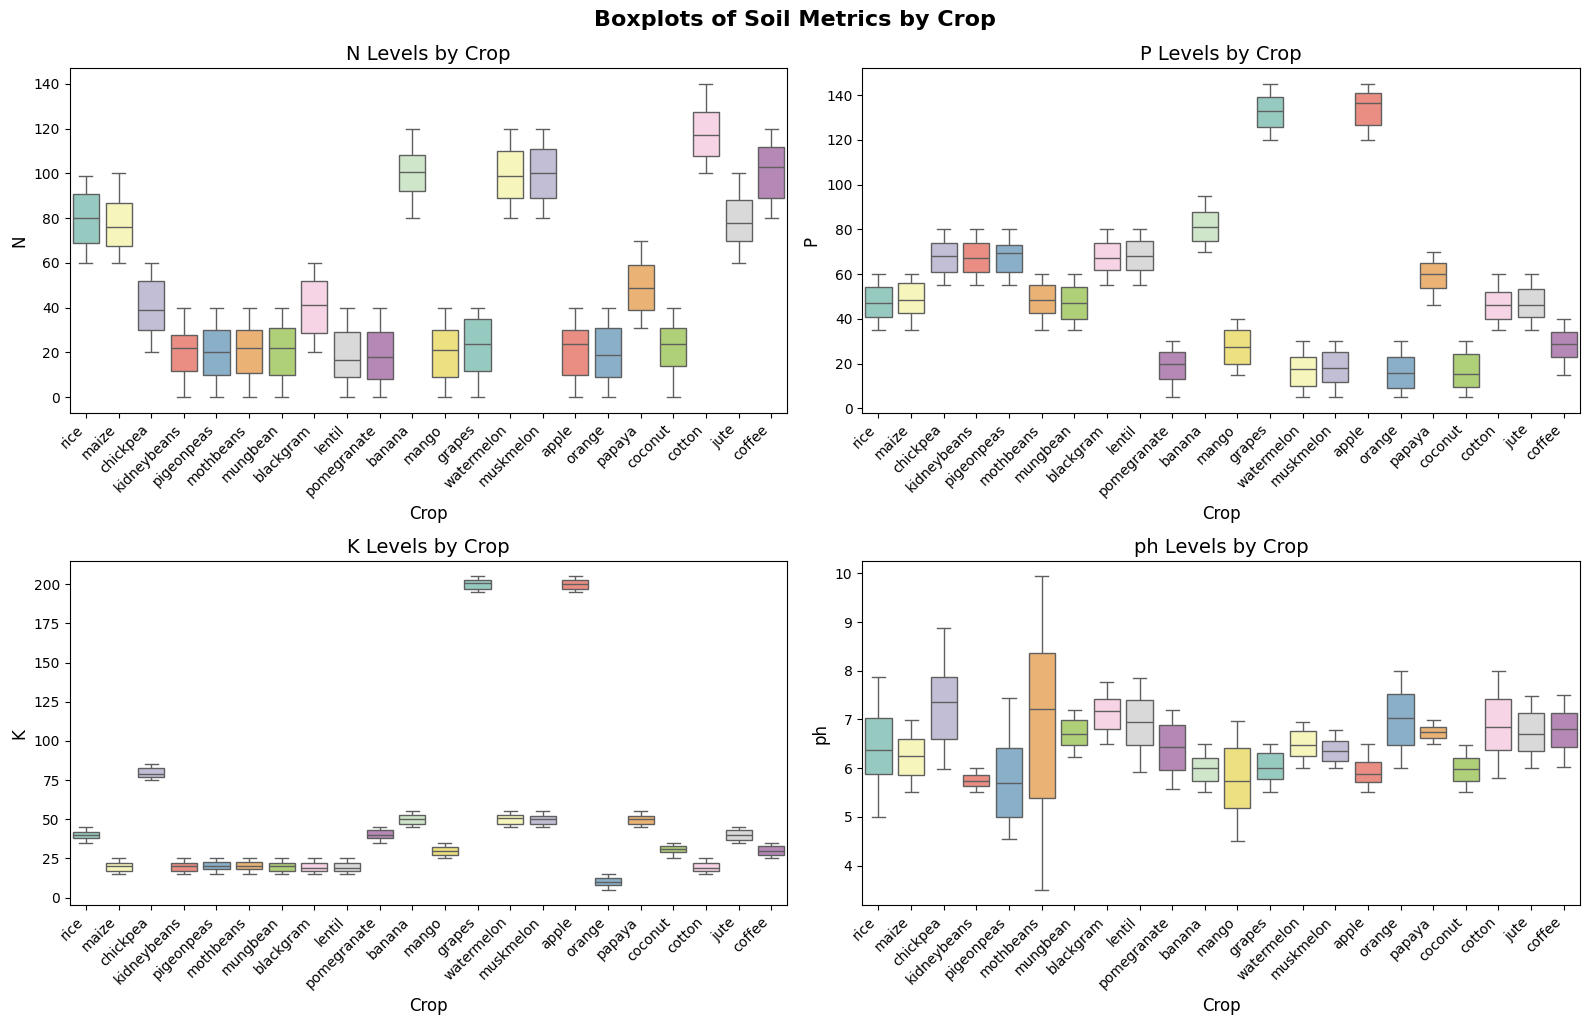

In [9]:
# Plot boxplots to visualize soil metrics (N, P, K, pH) by crop.
plt.figure(figsize=(16, 10))
metrics = ["N", "P", "K", "ph"]

for i, metric in enumerate(metrics, start=1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=metric, x="crop", hue="crop", data=soil_data, palette="Set3", legend=False, dodge=False)
    plt.title(f'{metric} Levels by Crop', fontsize=14)
    plt.xlabel("Crop", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.suptitle("Boxplots of Soil Metrics by Crop", fontsize=16, fontweight="bold", y=1.02)
plt.show()

In [10]:
# Check for missing values in the dataset.
print("Missing values in the dataset:", end="\n\n")
print(soil_data.isna().sum())

Missing values in the dataset:

N       0
P       0
K       0
ph      0
crop    0
dtype: int64


In [11]:
# Function to detect outliers using the IQR method.
def detect_outliers(column: str):
    """
    Detect outliers in a numeric column using the IQR method.

    Parameters:
        column (str): Name of the column to analyze.

    Returns:
        tuple: (number of outliers, lower bound, upper bound)
    """
    Q1 = soil_data[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = soil_data[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = soil_data[(soil_data[column] < lower_bound) | (soil_data[column] > upper_bound)]
    return outliers.shape[0], lower_bound, upper_bound

# Detect outliers for all numeric columns.
outlier_analysis = {metric: detect_outliers(metric) for metric in metrics}

# Display outlier counts and bounds for each metric.
print("Outlier analysis:", end="\n\n")
for metric, (count, lower, upper) in outlier_analysis.items():
    print(f"{metric}: {count} outliers (Lower Bound: {lower}, Upper Bound: {upper})")

Outlier analysis:

N: 0 outliers (Lower Bound: -73.875, Upper Bound: 179.125)
P: 138 outliers (Lower Bound: -32.0, Upper Bound: 128.0)
K: 200 outliers (Lower Bound: -23.5, Upper Bound: 92.5)
ph: 57 outliers (Lower Bound: 4.543768066249998, Upper Bound: 8.351567354250005)


**2) Data Preprocessing**

In [12]:
# Define features (X) and target (y).
X = soil_data.drop(columns=["crop"], axis=1)  # Features
y = soil_data["crop"]  # Target variable

# Split the dataset into training and testing sets.
# Stratify ensures that the class distribution in train and test sets matches the original dataset.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% of the data goes into the test set.
    random_state=RANDOM_SEED,  # Ensure reproducibility.
    stratify=y        # Maintain the proportion of each crop type in train and test sets.
)

# Display shapes of the resulting datasets for verification.
print(f"Training Features Shape: {X_train.shape}")
print(f"Test Features Shape:     {X_test.shape}")
print(f"Training Target Shape:   {y_train.shape}")
print(f"Test Target Shape:       {y_test.shape}")

Training Features Shape: (1760, 4)
Test Features Shape:     (440, 4)
Training Target Shape:   (1760,)
Test Target Shape:       (440,)


In [13]:
# Identify numeric and categorical features in the dataset.
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

# Pipeline for preprocessing numeric features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),  # Handle missing values by replacing with mean.
    ("scaler", RobustScaler())                    # Scale numeric features using RobustScaler.
])

# Pipeline for preprocessing categorical features
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing values with the most frequent value.
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     # Apply One-Hot Encoding for categorical variables.
])

# Combine the numeric and categorical preprocessors into a ColumnTransformer.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),         # Apply numeric transformer to numeric features.
        ("cat", categorical_transformer, categorical_features)  # Apply categorical transformer to categorical features.
    ]
)

**3. Model Training and Evaluation**


Model: Logistic Regression
Logistic Regression - Cross Validation Scores: [0.68797002 0.66556685 0.65532982 0.70148193 0.62619701]
Logistic Regression - Mean Cross Validation Score: 0.6673
Logistic Regression - Standard Deviation of CV Scores: 0.0262
Logistic Regression - 95% Confidence Interval: [0.62911029 0.70013074]

Model: KNN
KNN - Cross Validation Scores: [0.75868632 0.7696149  0.76124464 0.78037054 0.74682258]
KNN - Mean Cross Validation Score: 0.7633
KNN - Standard Deviation of CV Scores: 0.0112
KNN - 95% Confidence Interval: [0.74800895 0.77929497]

Model: Decision Tree
Decision Tree - Cross Validation Scores: [0.75369626 0.77931657 0.80881669 0.74833731 0.75380679]
Decision Tree - Mean Cross Validation Score: 0.7688
Decision Tree - Standard Deviation of CV Scores: 0.0227
Decision Tree - 95% Confidence Interval: [0.74887321 0.80586668]
Best Classifier Model: Decision Tree



<ipython-input-14-52cd4b8c72b2>:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=classifier_models.keys(), patch_artist=True,


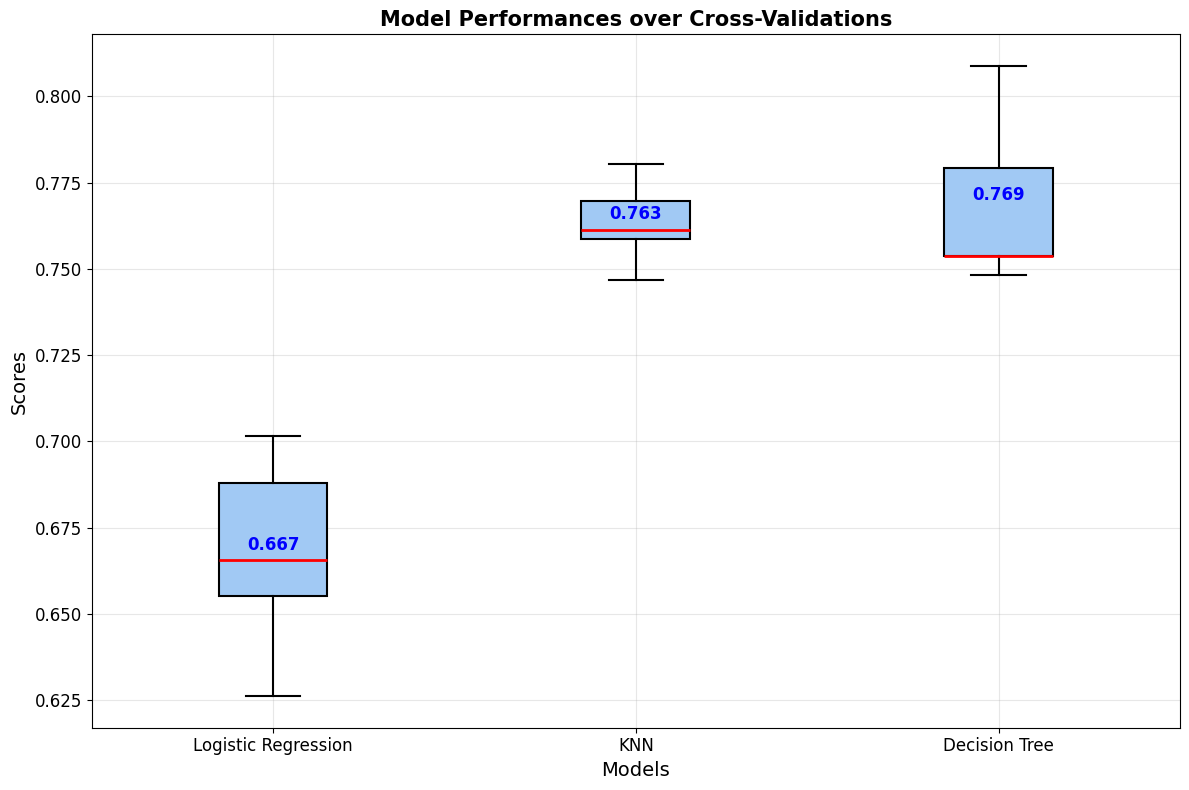

In [14]:
# Define classifier models.
classifier_models = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_SEED),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_SEED),
}

# Initialize a list to store results.
results = []

# Iterate over the classifier models.
for model_name, model in classifier_models.items():
    print(f"\nModel: {model_name}")

    # Create a pipeline with preprocessing and the current model.
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("classifier", model)])

    # Perform 5-Fold cross-validation.
    kf = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring="f1_weighted") # Use the scoring metric as weighted F1 score.
    results.append(cv_results)

    # Print cross-validation results.
    print(f"{model_name} - Cross Validation Scores: {cv_results}")
    print(f"{model_name} - Mean Cross Validation Score: {cv_results.mean():.4f}")
    print(f"{model_name} - Standard Deviation of CV Scores: {cv_results.std():.4f}")
    print(f"{model_name} - 95% Confidence Interval: {np.quantile(cv_results, [0.025, 0.975])}")

# Calculate the mean cross-validation score for each model.
mean_scores = [cv_result.mean() for cv_result in results]

# Find the index of the model with the highest mean score.
best_model_index = mean_scores.index(max(mean_scores))

# Retrieve the corresponding model name.
best_model_name = list(classifier_models.keys())[best_model_index]

# Print the best model name.
print("="*100)
print(f"Best Classifier Model: {best_model_name}")
print("="*100 + "\n")

# Create a boxplot to compare cross-validation scores across models.
plt.figure(figsize=(12, 8))
colors = sns.color_palette("pastel", len(classifier_models.keys())) # Colors for the boxes

plt.boxplot(results, labels=classifier_models.keys(), patch_artist=True,
            boxprops=dict(facecolor=colors[0], color="black", linewidth=1.5),
            medianprops=dict(color="red", linewidth=2), # Highlight the median with a bold red line.
            whiskerprops=dict(color="black", linewidth=1.5),
            capprops=dict(color="black", linewidth=1.5))

plt.title("Model Performances over Cross-Validations", fontsize=15, fontweight="bold")
plt.ylabel("Scores", fontsize=14)
plt.xlabel("Models", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Annotate mean values on the boxplot.
means = [result.mean() for result in results]
for i, mean in enumerate(means, start=1):
    plt.text(i, mean, f"{mean:.3f}", ha="center", va="bottom", fontsize=12, color="blue", fontweight="bold")

plt.tight_layout()
plt.show()

In [15]:
# Get the best classifier model.
best_model = classifier_models[best_model_name]

# Hyperparameter search space for Decision Tree.
param_grid = {
    'classifier__max_depth': [3, 5, 10, None],    # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'classifier__criterion': ["gini", "entropy"], # Splitting criterion
}

# GridSearchCV for hyperparameter tuning.
grid_search = GridSearchCV(
    Pipeline(steps=[("preprocessor", preprocessor),
                    ("classifier", best_model)]),
    param_grid=param_grid,
    cv=5,      # 5-fold cross-validation
    scoring="f1_weighted",  # Optimize for weighted F1 score.
    n_jobs=-1, # Use all available cores.
    verbose=1  # Print progress during the search.
)

# Fit the model using GridSearchCV.
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and the corresponding score.
print("="*160)
print(f"Best Hyperparameters: {grid_search.best_params_}", end="\n\n")
print(f"Best Cross Validation Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}

Best Cross Validation Score: 0.7893


Test Set Weighted F1 Score: 0.7614



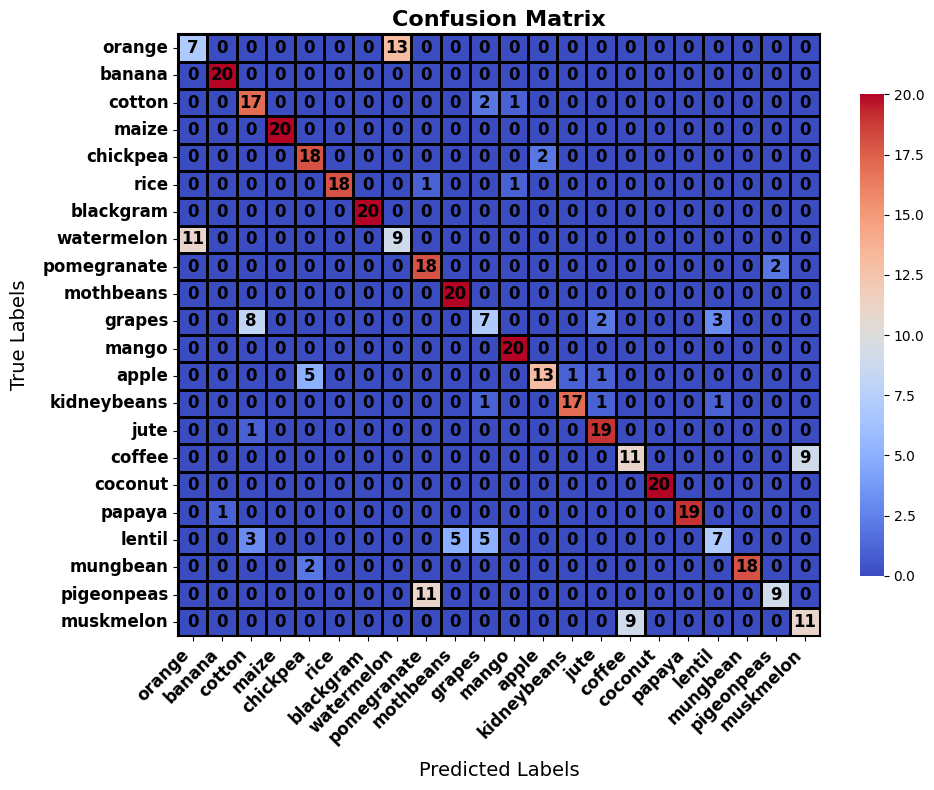


Classification Report:

              precision    recall  f1-score   support

       apple       0.39      0.35      0.37        20
      banana       0.95      1.00      0.98        20
   blackgram       0.59      0.85      0.69        20
    chickpea       1.00      1.00      1.00        20
     coconut       0.72      0.90      0.80        20
      coffee       1.00      0.90      0.95        20
      cotton       1.00      1.00      1.00        20
      grapes       0.41      0.45      0.43        20
        jute       0.60      0.90      0.72        20
 kidneybeans       0.80      1.00      0.89        20
      lentil       0.47      0.35      0.40        20
       maize       0.91      1.00      0.95        20
       mango       0.87      0.65      0.74        20
   mothbeans       0.94      0.85      0.89        20
    mungbean       0.83      0.95      0.88        20
   muskmelon       0.55      0.55      0.55        20
      orange       1.00      1.00      1.00        20
  

In [16]:
# Evaluate the best model on the test dataset.
# Retrieve the best model from GridSearchCV.
best_model_final = grid_search.best_estimator_

# Make predictions on the test set.
y_pred = best_model_final.predict(X_test)

# Compute the weighted F1 score for the test set.
f1 = f1_score(y_test, y_pred, average="weighted")

# Display the F1 score.
print(f"Test Set Weighted F1 Score: {f1:.4f}", end="\n\n")

# Visualize the confusion matrix as a heatmap.
conf_matrix = confusion_matrix(y_test, y_pred)  # Compute the confusion matrix.

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=y_test.unique(), yticklabels=y_test.unique(),
            linewidths=1, linecolor="black", cbar_kws={"shrink": 0.8, "orientation": "vertical"},
            annot_kws={"size": 12, "weight": "bold", "color": "black"})

plt.title("Confusion Matrix", fontsize=16, fontweight="bold")
plt.xlabel("Predicted Labels", fontsize=14, labelpad=10)
plt.ylabel("True Labels", fontsize=14, labelpad=10)

# Customize tick labels.
plt.xticks(fontsize=12, rotation=45, ha="right", fontweight="bold")
plt.yticks(fontsize=12, rotation=0, fontweight="bold")

# Add a border around the heatmap.
plt.gca().spines["top"].set_visible(True)
plt.gca().spines["right"].set_visible(True)
plt.gca().spines["bottom"].set_visible(True)
plt.gca().spines["left"].set_visible(True)
for spine in plt.gca().spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

# Display the classification report.
print("\nClassification Report:", end="\n\n")
class_report = classification_report(y_test, y_pred)  # Generate precision, recall, F1-score, and support.
print(class_report)

**4. Feature Importance**

Top features by importance:

  Feature  Importance
2       K    0.333436
1       P    0.276291
0       N    0.209631
3      ph    0.180643


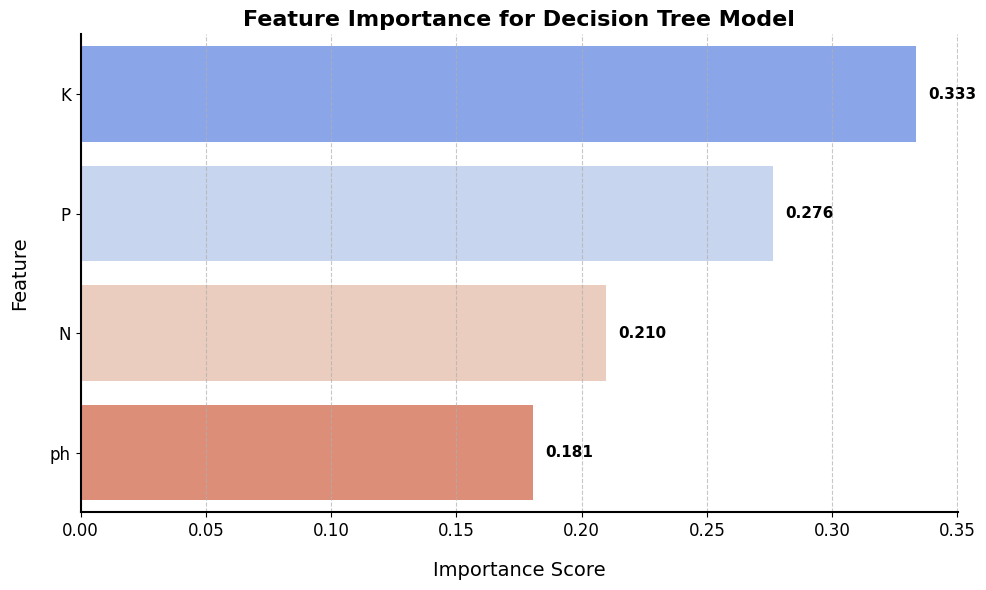

In [17]:
# Extract the best model from the grid search.
best_model_final = grid_search.best_estimator_

# Get preprocessor and classifier from the pipeline.
preprocessor = best_model_final.named_steps["preprocessor"]
classifier = best_model_final.named_steps["classifier"]

# Check if the classifier supports feature importances.
if hasattr(classifier, "feature_importances_"):
    # Retrieve feature importances.
    feature_importances = classifier.feature_importances_
else:
    raise ValueError("The selected classifier does not have feature importances.")

# Retrieve feature names.
# Numeric feature names remain unchanged.
numeric_feature_names = numeric_features.tolist()

# Fit the OneHotEncoder to the training data to extract categorical feature names.
preprocessor.named_transformers_["cat"].named_steps["onehot"].fit(X_train[categorical_features])
categorical_feature_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_features)

# Combine numeric and categorical feature names.
all_feature_names = numeric_feature_names + categorical_feature_names.tolist()

# Create a DataFrame for feature importances.
importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display the top features.
print("Top features by importance:", end="\n\n")
print(importance_df.head(10))

# Visualize feature importance.
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", hue="Feature", data=importance_df, palette="coolwarm", legend=False)
plt.title(f"Feature Importance for {best_model_name} Model", fontsize=16, fontweight="bold")
plt.xlabel("Importance Score", fontsize=14, labelpad=15)
plt.ylabel("Feature", fontsize=14, labelpad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines and spines customization.
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_linewidth(1.5)
plt.gca().spines["bottom"].set_linewidth(1.5)

# Add annotations for importance values.
for i, row in enumerate(importance_df.itertuples()):
    plt.text(row.Importance + 0.005, i, f"{row.Importance:.3f}",
             va="center", ha="left", fontsize=11, color="black", fontweight="bold")

plt.tight_layout()
plt.show()

The single feature that has the strongest predictive performance for classifying crop types is `"K"`.